In [1]:
import tensorflow as tf
import os
import zipfile

# --- 1. Download the zip files ---
train_url = "https://storage.googleapis.com/learning-datasets/rps.zip"
validation_url = "https://storage.googleapis.com/learning-datasets/rps-test-set.zip"

# Download the training data zip (without extracting)
path_to_train_zip = tf.keras.utils.get_file('rps.zip', origin=train_url, extract=False)

# Download the validation data zip (without extracting)
path_to_validation_zip = tf.keras.utils.get_file('rps-test-set.zip', origin=validation_url, extract=False)


# --- 2. Manually Unzip the Files ---
# Define the directory to extract to
extract_dir = os.path.join(os.path.dirname(path_to_train_zip))

# Unzip the training data
with zipfile.ZipFile(path_to_train_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Unzip the validation data
with zipfile.ZipFile(path_to_validation_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


# --- 3. Define the Correct Paths to the Extracted Folders ---
# The zips create 'rps' and 'rps-test-set' folders when extracted
train_dir = os.path.join(extract_dir, 'rps')
validation_dir = os.path.join(extract_dir, 'rps-test-set')


# --- 4. Create the DataLoaders ---
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE
)

class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Successfully loaded {num_classes} classes: {class_names}")

print("\n✅ Data is ready! This explicit method will work.")

200682221/200682221 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
29516758/29516758 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.
Successfully loaded 3 classes: ['paper', 'rock', 'scissors']

✅ Data is ready! This explicit method will work.


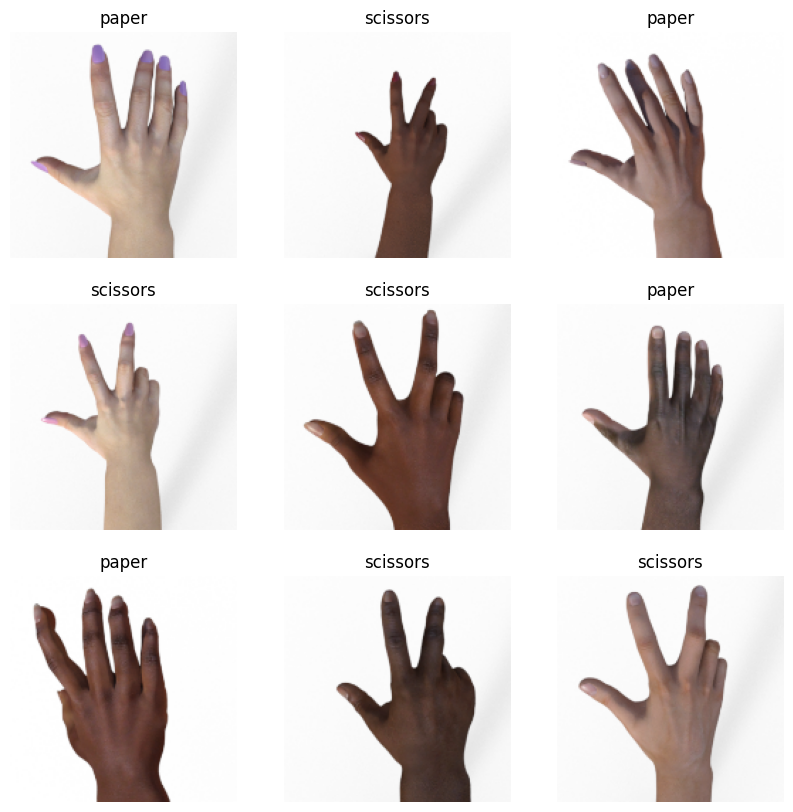

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve one batch of images and labels from the training dataset
image_batch, label_batch = next(iter(train_dataset))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")
plt.show()

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

rescale = layers.Rescaling(1./127.5, offset=-1)

In [4]:
# Load the pre-trained base model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model so we don't ruin its learned features
base_model.trainable = False

# Create our new model by chaining all the pieces together
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # from_logits=False is safer
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
EPOCHS = 10
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.5957 - loss: 0.9747 - val_accuracy: 0.9140 - val_loss: 0.3012
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9417 - loss: 0.1931 - val_accuracy: 0.8978 - val_loss: 0.2962
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.9693 - loss: 0.1144 - val_accuracy: 0.8952 - val_loss: 0.2945
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9756 - loss: 0.0875 - val_accuracy: 0.9220 - val_loss: 0.2315
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.9836 - loss: 0.0706 - val_accuracy: 0.9220 - val_loss: 0.2088
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9915 - loss: 0.0447 - val_accuracy: 0.9086 - val_loss: 0.2393
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9839 - loss: 0.0550 - val_accuracy: 0.9220 - val_loss: 0.2161
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.9920 - loss: 0.0445 - val_accuracy: 0.938

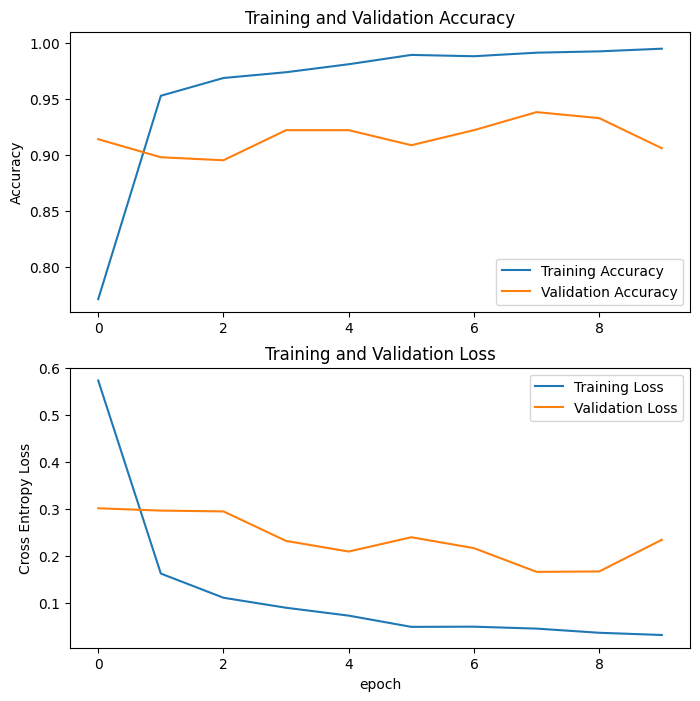

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.01])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [9]:
model.save('rock_paper_scissors_model.keras')